In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import contractions
import nltk
import string
import seaborn as sns
import numpy as np
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
training_set = pd.read_json('./data/train_set.json')
test_set = pd.read_json('./data/test_set.json')


In [5]:
training_set.head(5)

,id,text,label
0,0,Remains dating to the 5th century were found i...,1
1,1,Professional Identification is a type of socia...,1
2,2,A magistrate has refused a media ban on the tr...,1
3,3,The Conservation Commons is the expression of ...,1
4,4,Myer is holding a 75 per cent of designer labe...,0


In [6]:
test_set.head(5)

,id,text
0,0,David Cameron revealed he and his wife Samanth...
1,1,David Cameron appeared to forget which footbal...
2,2,Ebola tests for a senior doctor has come back ...
3,3,Celebrity chef's Fat Duck named eighth best re...
4,4,"Navinder Singh Sarao , 36 , is accused of maki..."


In [7]:
ta = training_set.copy() # training text analyse


## label distribution

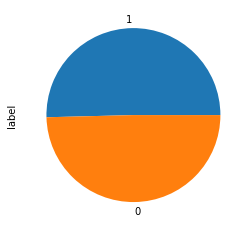

In [8]:
ta['label'].value_counts().plot.pie()
plt.show()

## text length

In [9]:
ta['no_contract'] = ta['text'].apply(lambda x: contractions.fix(x))
ta['tokenized'] = ta['no_contract'].apply(nltk.word_tokenize)

In [41]:
punc = string.punctuation
ta['no_punc'] = ta['tokenized'].apply(lambda x: [word for word in x if word not in punc])
ta['punc'] = ta['tokenized'].apply(lambda x: [word for word in x if word in punc])
ta['lower'] = ta['no_punc'].apply(lambda x: [word.lower() for word in x])

stop_words = set(nltk.corpus.stopwords.words('english'))
ta['stopwords_removed'] = ta['lower'].apply(lambda x: [word for word in x if word not in stop_words])

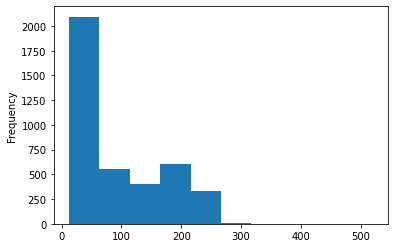

(97.62325, 521)

In [42]:
ta['with_stop_word_count'] = ta['lower'].apply(len)
ta['with_stop_word_count'].plot.hist()
plt.show()
ta['with_stop_word_count'].mean(), ta['with_stop_word_count'].max()

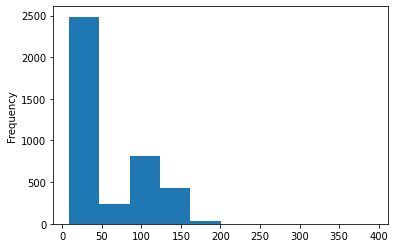

(59.94875, 393)

In [43]:
ta['without_stop_word_count'] = ta['stopwords_removed'].apply(len)
ta['without_stop_word_count'].plot.hist()
plt.show()
ta['without_stop_word_count'].mean(), ta['without_stop_word_count'].max()

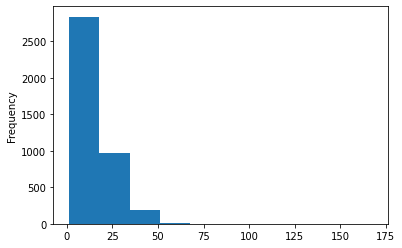

(12.53925, 168)

In [44]:
ta['punc_count'] = ta['punc'].apply(len)
ta['punc_count'].plot.hist()
plt.show()
ta['punc_count'].mean(), ta['punc_count'].max()

<AxesSubplot:>

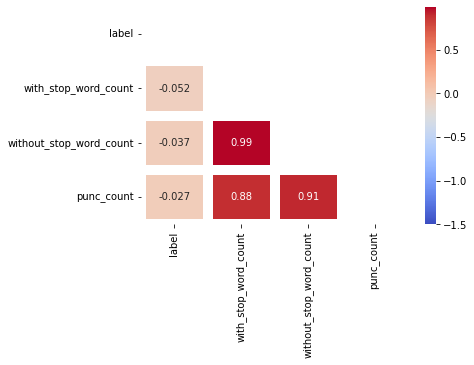

In [45]:
correlation = ta[['label', 'with_stop_word_count', 'without_stop_word_count', 'punc_count']].corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation, cmap='coolwarm', annot=True, linewidths=10, vmin=-1.5, mask=mask)

## word frequency

In [46]:
ta['pos_tags'] = ta['stopwords_removed'].apply(nltk.tag.pos_tag)
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN
ta['wordnet_pos'] = ta['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = nltk.stem.WordNetLemmatizer()
ta['lemmatized'] = ta['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [47]:
words = ta['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords[:100])

['remains', 'date', '5th', 'century', 'find', 'tomb', 'hwangnam-dong', 'show', 'man', "'s", 'bone', 'top', 'woman', "'s", 'bury', 'jewellery', 'expert', 'believe', 'silla', 'dynasty-era', 'tomb', 'build', 'noblewoman', 'lover', 'bodyguard', 'sacrifice', 'bury', 'top', "'s", 'suggestion', 'set-up', 'may', 'design', 'show', 'two', 'people', 'sex', 'silla', 'know', 'explicit', 'pottery', 'professional', 'identification', 'type', 'social', 'identification', 'sense', 'oneness', 'individual', 'profession', 'e.g', 'law', 'medicine', 'degree', 'individual', 'define', 'profession', 'member', 'professional', 'identity', 'consist', 'individual', "'s", 'alignment', 'role', 'responsibility', 'value', 'ethical', 'standard', 'consistent', 'practice', 'accept', 'specific', 'profession', 'source', 'professional', 'identification', 'researcher', 'find', 'desire', 'quality', 'rather', 'profit', 'associate', 'professional', 'identification', 'organization', 'tend', 'concerned', 'efficiency', 'profitabilit

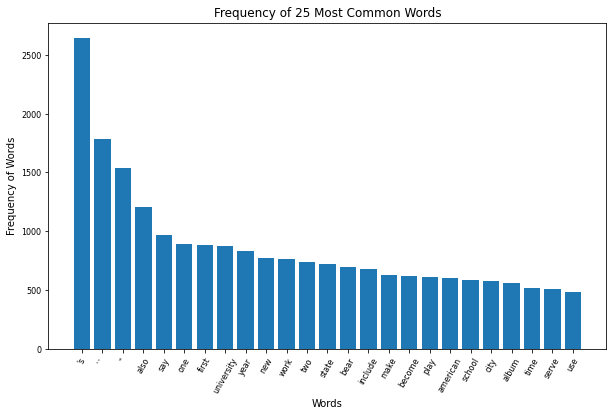

In [50]:
mostcommon_small = nltk.probability.FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(rotation=60, fontsize=8)
plt.title('Frequency of 25 Most Common Words', fontsize=12)
plt.show()

In [56]:
words = ta[ta['label']==1]['lemmatized']
allwords_1 = []
for wordlist in words:
    allwords_1 += wordlist
print(allwords_1[:100])

['remains', 'date', '5th', 'century', 'find', 'tomb', 'hwangnam-dong', 'show', 'man', "'s", 'bone', 'top', 'woman', "'s", 'bury', 'jewellery', 'expert', 'believe', 'silla', 'dynasty-era', 'tomb', 'build', 'noblewoman', 'lover', 'bodyguard', 'sacrifice', 'bury', 'top', "'s", 'suggestion', 'set-up', 'may', 'design', 'show', 'two', 'people', 'sex', 'silla', 'know', 'explicit', 'pottery', 'professional', 'identification', 'type', 'social', 'identification', 'sense', 'oneness', 'individual', 'profession', 'e.g', 'law', 'medicine', 'degree', 'individual', 'define', 'profession', 'member', 'professional', 'identity', 'consist', 'individual', "'s", 'alignment', 'role', 'responsibility', 'value', 'ethical', 'standard', 'consistent', 'practice', 'accept', 'specific', 'profession', 'source', 'professional', 'identification', 'researcher', 'find', 'desire', 'quality', 'rather', 'profit', 'associate', 'professional', 'identification', 'organization', 'tend', 'concerned', 'efficiency', 'profitabilit

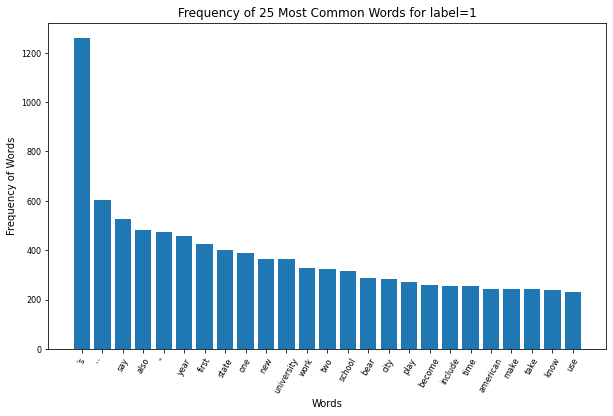

In [57]:
mostcommon_small = nltk.probability.FreqDist(allwords_1).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(rotation=60, fontsize=8)
plt.title('Frequency of 25 Most Common Words for label=1', fontsize=12)
plt.show()

In [58]:
words = ta[ta['label']==0]['lemmatized']
allwords_0 = []
for wordlist in words:
    allwords_0 += wordlist
print(allwords_0[:100])

['myer', 'hold', '75', 'per', 'cent', 'designer', 'label', 'sale', 'wednesday', '22nd', 'department', 'store', 'understood', 'broker', 'deal', 'stock', 'international', 'designer', 'collection', 'time', 'european', 'american', 'retailer', 'move', 'say', 'attempt', 'revive', 'iconic', 'department', 'store', "'s", 'australian', 'market', 'bergen-belsen', 'concentration', 'camp', 'germany', 'liberate', 'british', 'canadian', 'troop', '1945', 'become', 'final', 'resting', 'place', '50,000', 'jew', 'gypsy', 'homosexual', 'nazi', 'opponent', 'disable', 'reverend', 'charles', 'martin', 'king', 'parson', 'one', 'handful', 'chaplains', 'helped', 'liberate', 'take', 'image', 'jonas', 'gutierrez', 'trigger', 'contract', 'extension', 'start', 'remain', 'seven', 'match', 'season', 'argentine', 'twice', 'beaten', 'testicular', 'cancer', '31-year-old', 'say', 'never', 'forgive', 'newcastle', 'handle', 'illness', 'one', 'game', 'closer', 'win', 'new', 'contract', 'st', 'james', 'park', 'five', 'americ

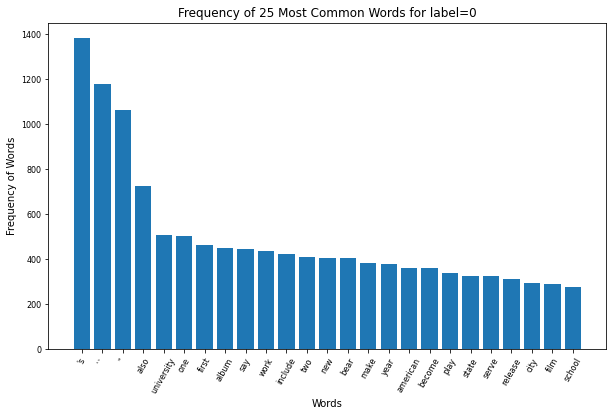

In [59]:
mostcommon_small = nltk.probability.FreqDist(allwords_0).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(rotation=60, fontsize=8)
plt.title('Frequency of 25 Most Common Words for label=0', fontsize=12)
plt.show()

In [67]:
counter_1 = Counter(allwords_1)
counter_0 = Counter(allwords_0)

diff_dict = dict()
for word in set(allwords_1 + allwords_0):
    diff = (counter_1[word] - counter_0[word])
    diff_dict[word] = diff

sorted_diff = sorted(diff_dict.items(), key=lambda x: x[1], reverse=True)
top = sorted_diff[:25]

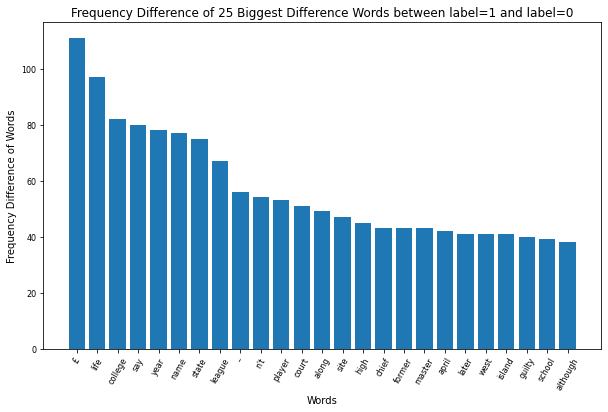

In [68]:
x, y = zip(*top)
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency Difference of Words', fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(rotation=60, fontsize=8)
plt.title('Frequency Difference of 25 Biggest Difference Words between label=1 and label=0', fontsize=12)
plt.show()